In [1]:
addprocs(4)
using SeisIO, HDF5, PyPlot, JUDI.TimeModeling, JUDI.SLIM_optim

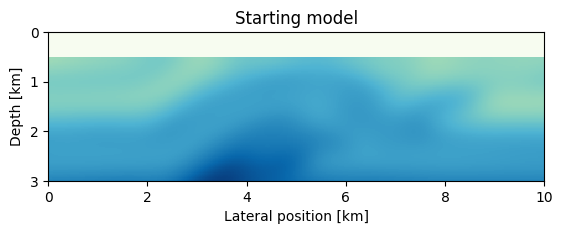

In [2]:
m0, n, d, o = read(h5open("overthrust_model.h5","r"),"m0","n","d","o"); title("Starting model")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0);
imshow(sqrt.(1f0./m0)', cmap="GnBu", extent=(0,10,3,0));
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [3]:
block = segy_read("overthrust_shot_records.segy");
d_obs = judiVector(block);

In [4]:
println(typeof(d_obs))

JUDI.TimeModeling.judiVector{Float32}


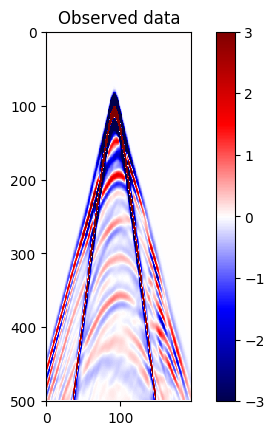

PyObject <matplotlib.text.Text object at 0x129da9e50>

In [5]:
imshow(d_obs.data[15], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Observed data")

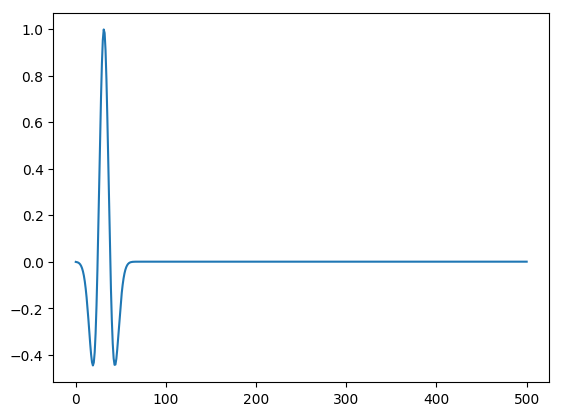

In [6]:
src_geometry = Geometry(block; key="source");
src_data = ricker_wavelet(src_geometry.t[1], src_geometry.dt[1], 0.008f0);
q = judiVector(src_geometry, src_data);
plot(q.data[1]);

In [7]:
ntComp = get_computational_nt(q.geometry, d_obs.geometry, model0);
info = Info(prod(model0.n), d_obs.nsrc, ntComp);

In [8]:
Ainv = judiModeling(info, model0);
Pr = judiProjection(info, d_obs.geometry);
Ps = judiProjection(info, q.geometry);

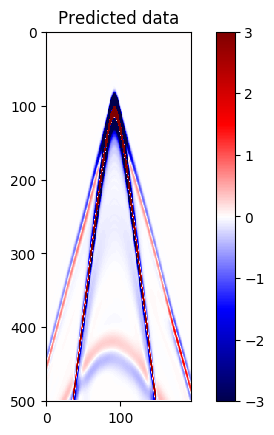

PyObject <matplotlib.text.Text object at 0x12a722250>

In [9]:
i = 15;
d_pred = Pr[i]*Ainv[i]*Ps[i]'*q[i];
imshow(d_pred.data[1], cmap="seismic", vmin=-3, vmax=3); colorbar(); title("Predicted data")

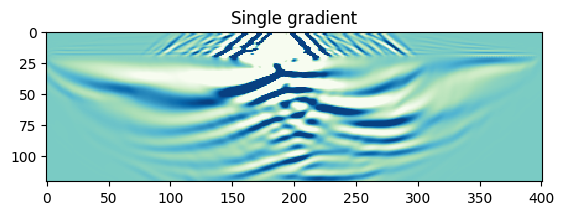

PyObject <matplotlib.text.Text object at 0x12d4e7fd0>

In [10]:
J = judiJacobian(Pr*Ainv*Ps',q);
#H_GN = J'*J    # Gauss-Newton Hessian
g = J[i]'*(d_pred - d_obs[i]);
imshow(reshape(g,model0.n)',vmin=-2e2,vmax=2e2, cmap="GnBu"); title("Single gradient")

This is a markdown cell $\mathbf{Ax} = \mathbf{b}$

In [11]:
# Set up bound constrains
v0 = sqrt.(1f0./model0.m)
vmin = ones(Float32, model0.n)*1.3f0;
vmax = ones(Float32, model0.n)*6.5f0;

# Fix water column
vmin[:,1:21] = v0[:,1:21];
vmax[:,1:21] = v0[:,1:21];

# Convert to squared slowness
mmin = vec((1f0./vmax).^2);
mmax = vec((1f0./vmin).^2);

In [12]:
maxiter = 10
batchsize = 8
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)],2), model0.n)
fhistory = zeros(Float32,maxiter)

# Main loop
for j=1:maxiter
    println("Iteration: ",j)
    
    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    fhistory[j] = fval

    # linesearch
    step = backtracking_linesearch(model0, q[i], d_obs[i], fval, gradient, proj; alpha=1f0)
    model0.m = proj(model0.m + reshape(step, model0.n))
    
end

Iteration: 1
	Iter LS: 1; 161036.5 <= 97315.44; alpha: 1.0
	Iter LS: 2; 25095.08 <= 97462.02; alpha: 0.1
Iteration: 2
	Iter LS: 1; 207215.12 <= 72455.46; alpha: 1.0
	Iter LS: 2; 20850.105 <= 72576.81; alpha: 0.1
Iteration: 3
	Iter LS: 1; 151710.48 <= 47547.805; alpha: 1.0
	Iter LS: 2; 22828.738 <= 47631.953; alpha: 0.1
Iteration: 4
	Iter LS: 1; 197038.75 <= 38880.844; alpha: 1.0
	Iter LS: 2; 15312.153 <= 38954.164; alpha: 0.1
Iteration: 5
	Iter LS: 1; 282594.6 <= 35578.047; alpha: 1.0
	Iter LS: 2; 75055.79 <= 35796.28; alpha: 0.1
	Iter LS: 3; 11055.386 <= 35818.105; alpha: 0.010000001
Iteration: 6
	Iter LS: 1; 189801.44 <= 30338.797; alpha: 1.0
	Iter LS: 2; 9595.961 <= 30387.732; alpha: 0.1
Iteration: 7
	Iter LS: 1; 203382.47 <= 20702.375; alpha: 1.0
	Iter LS: 2; 43868.39 <= 20789.482; alpha: 0.1
	Iter LS: 3; 7723.564 <= 20798.191; alpha: 0.010000001
Iteration: 8
	Iter LS: 1; 108689.07 <= 16739.41; alpha: 1.0
	Iter LS: 2; 6790.471 <= 16778.158; alpha: 0.1
Iteration: 9
	Iter LS: 1; 1287

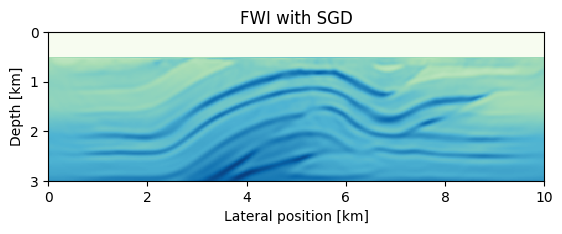

In [13]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with SGD")
xlabel("Lateral position [km]");
ylabel("Depth [km]");

In [17]:
# Optimization parameters
using IterativeSolvers
model0.m = m0    # reset velocity model
maxiter_GN = 5
fhistory_GN = zeros(Float32,maxiter)

# Gauss-Newton method
for j=1:maxiter
    println("Iteration: ",j)

    # Model predicted data for subset of sources
    d_pred = Pr*Ainv*Ps'*q
    fhistory_GN[j] = .5f0*norm(d_pred - d_obs)^2
                        
    # GN update direction
    p = lsqr(J, d_pred - d_obs; maxiter=maxiter_GN, verbose=true)
                                                                                
    # update model and bound constraints
    model0.m = proj(model0.m - reshape(p, model0.n))    # alpha=1
end

Iteration: 1
=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	4.97e+02	1.01e+00	2.55e-02	6.97e-01
  2	3.45e+02	4.25e-01	9.51e-03	4.83e-01
  3	2.89e+02	2.53e-01	5.92e-03	4.05e-01
  4	2.44e+02	2.31e-01	4.14e-03	3.43e-01
  5	2.15e+02	1.54e-01	3.13e-03	3.01e-01
  6	1.96e+02	1.39e-01	2.51e-03	2.75e-01

Iteration: 2
=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	3.08e+02	6.30e-01	2.52e-02	6.89e-01
  2	2.30e+02	4.06e-01	1.09e-02	5.15e-01
  3	1.85e+02	2.69e-01	6.57e-03	4.13e-01
  4	1.58e+02	2.38e-01	4.54e-03	3.53e-01
  5	1.36e+02	1.87e-01	3.34e-03	3.04e-01
  6	1.22e+02	1.48e-01	2.62e-03	2.74e-01

Iteration: 3
=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	2.04e+02	7.40e-01	2.50e-02	7.52e-01
  2	1.48e+02	4.07e-01	9.93e-03	5.46e-01
  3	1.24e+02	2.57e-01	6.08e-03	4.56e-01
  4	1.06e+02	2.46e-01	4.16e-03	3.89e-01
  5	9.10e+01	2.04e-01	3.04e-03	3.35e-01
  6	8.09e+01	1.64e-01	2.36e-03	2.98e-01

Iteration: 4
=== lsqr ===
iter	resnorm		  anorm		  cnorm		  rnorm
  1	1.52e+02	

ERROR (unhandled task failure): InterruptException:
Stacktrace:
 [1] process_events at ./libuv.jl:82 [inlined]
 [2] wait() at ./event.jl:216
 [3] wait(::Condition) at ./event.jl:27
 [4] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:42
 [5] wait(::Timer) at ./event.jl:357
 [6] (::Base.##300#301{IJulia.#send_stderr,Timer})() at ./event.jl:430


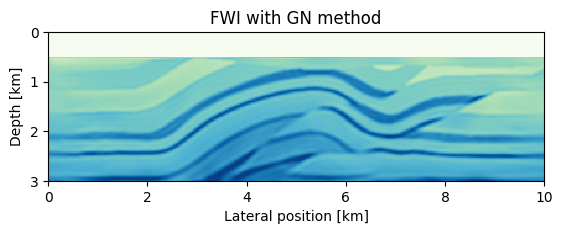

In [18]:
imshow(sqrt.(1f0./model0.m)', cmap="GnBu", extent=(0,10,3,0), vmin=1.5, vmax=5.4); title("FWI with GN method")
xlabel("Lateral position [km]");
ylabel("Depth [km]");